In [2]:
# import libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, re, time, math, tqdm, itertools
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.offline as pyo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier
import keras
from keras.layers import Conv2D, Conv1D, MaxPooling2D, MaxPooling1D, Flatten, BatchNormalization, Dense
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.callbacks import CSVLogger, ModelCheckpoint

In [3]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/ids-intrusion-csv/02-28-2018.csv
/kaggle/input/ids-intrusion-csv/03-01-2018.csv
/kaggle/input/ids-intrusion-csv/02-16-2018.csv
/kaggle/input/ids-intrusion-csv/02-15-2018.csv
/kaggle/input/ids-intrusion-csv/02-21-2018.csv
/kaggle/input/ids-intrusion-csv/03-02-2018.csv
/kaggle/input/ids-intrusion-csv/02-22-2018.csv
/kaggle/input/ids-intrusion-csv/02-20-2018.csv
/kaggle/input/ids-intrusion-csv/02-14-2018.csv
/kaggle/input/ids-intrusion-csv/02-23-2018.csv


In [4]:
!nvidia-smi

Sun Dec 31 19:40:00 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
%%time
df_d1 = pd.read_csv("/kaggle/input/ids-intrusion-csv/02-14-2018.csv", low_memory=False)
df_d2 = pd.read_csv("/kaggle/input/ids-intrusion-csv/02-15-2018.csv", low_memory=False)
df_d3 = pd.read_csv("/kaggle/input/ids-intrusion-csv/02-16-2018.csv", low_memory=False)
# df_d4 = pd.read_csv("/kaggle/input/ids-intrusion-csv/02-20-2018.csv", low_memory=False)
df_d5 = pd.read_csv("/kaggle/input/ids-intrusion-csv/02-21-2018.csv", low_memory=False)
df_d6 = pd.read_csv("/kaggle/input/ids-intrusion-csv/02-22-2018.csv", low_memory=False)
df_d7 = pd.read_csv("/kaggle/input/ids-intrusion-csv/02-23-2018.csv", low_memory=False)
df_d8 = pd.read_csv("/kaggle/input/ids-intrusion-csv/02-28-2018.csv", low_memory=False)
df_d9 = pd.read_csv("/kaggle/input/ids-intrusion-csv/03-01-2018.csv", low_memory=False)
df_d10 = pd.read_csv("/kaggle/input/ids-intrusion-csv/03-02-2018.csv", low_memory=False)

CPU times: user 2min 4s, sys: 10.1 s, total: 2min 15s
Wall time: 2min 50s


In [6]:
def fix_data_type(df):
    
    df = df[df['Dst Port'] != 'Dst Port']
    
    df['Dst Port'] = df['Dst Port'].astype(int)
    df['Protocol'] = df['Protocol'].astype(int)
    df['Flow Duration'] = df['Flow Duration'].astype(int)
    df['Tot Fwd Pkts'] = df['Tot Fwd Pkts'].astype(int)
    df['Tot Bwd Pkts'] = df['Tot Bwd Pkts'].astype(int)
    df['TotLen Fwd Pkts'] = df['TotLen Fwd Pkts'].astype(int)
    df['TotLen Bwd Pkts'] = df['TotLen Bwd Pkts'].astype(int)
    df['Fwd Pkt Len Max'] = df['Fwd Pkt Len Max'].astype(int)
    df['Fwd Pkt Len Min'] = df['Fwd Pkt Len Min'].astype(int)
    df['Fwd Pkt Len Mean'] = df['Fwd Pkt Len Mean'].astype(float)
    df['Fwd Pkt Len Std'] = df['Fwd Pkt Len Std'].astype(float)
    df['Bwd Pkt Len Max'] = df['Bwd Pkt Len Max'].astype(int)
    df['Bwd Pkt Len Min'] = df['Bwd Pkt Len Min'].astype(int)
    df['Bwd Pkt Len Mean'] = df['Bwd Pkt Len Mean'].astype(float)
    df['Bwd Pkt Len Std'] = df['Bwd Pkt Len Std'].astype(float)
    df['Flow Byts/s'] = df['Flow Byts/s'].astype(float)
    df['Flow Pkts/s'] = df['Flow Pkts/s'].astype(float)
    df['Flow IAT Mean'] = df['Flow IAT Mean'].astype(float)
    df['Flow IAT Std'] = df['Flow IAT Std'].astype(float)
    df['Flow IAT Max'] = df['Flow IAT Max'].astype(int)
    df['Flow IAT Min'] = df['Flow IAT Min'].astype(int)
    df['Fwd IAT Tot'] = df['Fwd IAT Tot'].astype(int)
    df['Fwd IAT Mean'] = df['Fwd IAT Mean'].astype(float)
    df['Fwd IAT Std'] = df['Fwd IAT Std'].astype(float)
    df['Fwd IAT Max'] = df['Fwd IAT Max'].astype(int)
    df['Fwd IAT Min'] = df['Fwd IAT Min'].astype(int)
    df['Bwd IAT Tot'] = df['Bwd IAT Tot'].astype(int)
    df['Bwd IAT Mean'] = df['Bwd IAT Mean'].astype(float)
    df['Bwd IAT Std'] = df['Bwd IAT Std'].astype(float)
    df['Bwd IAT Max'] = df['Bwd IAT Max'].astype(int)
    df['Bwd IAT Min'] = df['Bwd IAT Min'].astype(int)
    df['Fwd PSH Flags'] = df['Fwd PSH Flags'].astype(int)
    df['Bwd PSH Flags'] = df['Bwd PSH Flags'].astype(int)
    df['Fwd URG Flags'] = df['Fwd URG Flags'].astype(int)
    df['Bwd URG Flags'] = df['Bwd URG Flags'].astype(int)
    df['Fwd Header Len'] = df['Fwd Header Len'].astype(int)
    df['Bwd Header Len'] = df['Bwd Header Len'].astype(int)
    df['Fwd Pkts/s'] = df['Fwd Pkts/s'].astype(float)
    df['Bwd Pkts/s'] = df['Bwd Pkts/s'].astype(float)
    df['Pkt Len Min'] = df['Pkt Len Min'].astype(int)
    df['Pkt Len Max'] = df['Pkt Len Max'].astype(int)
    df['Pkt Len Mean'] = df['Pkt Len Mean'].astype(float)
    df['Pkt Len Std'] = df['Pkt Len Std'].astype(float)
    df['Pkt Len Var'] = df['Pkt Len Var'].astype(float)
    df['FIN Flag Cnt'] = df['FIN Flag Cnt'].astype(int)
    df['SYN Flag Cnt'] = df['SYN Flag Cnt'].astype(int)
    df['RST Flag Cnt'] = df['RST Flag Cnt'].astype(int)
    df['PSH Flag Cnt'] = df['PSH Flag Cnt'].astype(int)
    df['ACK Flag Cnt'] = df['ACK Flag Cnt'].astype(int)
    df['URG Flag Cnt'] = df['URG Flag Cnt'].astype(int)
    df['CWE Flag Count'] = df['CWE Flag Count'].astype(int)
    df['ECE Flag Cnt'] = df['ECE Flag Cnt'].astype(int)
    df['Down/Up Ratio'] = df['Down/Up Ratio'].astype(int)
    df['Pkt Size Avg'] = df['Pkt Size Avg'].astype(float)
    df['Fwd Seg Size Avg'] = df['Fwd Seg Size Avg'].astype(float)
    df['Bwd Seg Size Avg'] = df['Bwd Seg Size Avg'].astype(float)
    df['Fwd Byts/b Avg'] = df['Fwd Byts/b Avg'].astype(int)
    df['Fwd Pkts/b Avg'] = df['Fwd Pkts/b Avg'].astype(int)
    df['Fwd Blk Rate Avg'] = df['Fwd Blk Rate Avg'].astype(int)
    df['Bwd Byts/b Avg'] = df['Bwd Byts/b Avg'].astype(int)
    df['Bwd Pkts/b Avg'] = df['Bwd Pkts/b Avg'].astype(int)
    df['Bwd Blk Rate Avg'] = df['Bwd Blk Rate Avg'].astype(int)
    df['Subflow Fwd Pkts'] = df['Subflow Fwd Pkts'].astype(int)
    df['Subflow Fwd Byts'] = df['Subflow Fwd Byts'].astype(int)
    df['Subflow Bwd Pkts'] = df['Subflow Bwd Pkts'].astype(int)
    df['Subflow Bwd Byts'] = df['Subflow Bwd Byts'].astype(int)
    df['Init Fwd Win Byts'] = df['Init Fwd Win Byts'].astype(int)
    df['Init Bwd Win Byts'] = df['Init Bwd Win Byts'].astype(int)
    df['Fwd Act Data Pkts'] = df['Fwd Act Data Pkts'].astype(int)
    df['Fwd Seg Size Min'] = df['Fwd Seg Size Min'].astype(int)
    df['Active Mean'] = df['Active Mean'].astype(float)
    df['Active Std'] = df['Active Std'].astype(float)
    df['Active Max'] = df['Active Max'].astype(int)
    df['Active Min'] = df['Active Min'].astype(int)
    df['Idle Mean'] = df['Idle Mean'].astype(float)
    df['Idle Std'] = df['Idle Std'].astype(float)
    df['Idle Max'] = df['Idle Max'].astype(int)
    df['Idle Min'] = df['Idle Min'].astype(int)
    
    return df

In [8]:
%%time
df_d1 = fix_data_type(df_d1)
df_d2 = fix_data_type(df_d2)
df_d3 = fix_data_type(df_d3)
# df_d4 = fix_data_type(df_d4)
df_d5 = fix_data_type(df_d5)
df_d6 = fix_data_type(df_d6)
df_d7 = fix_data_type(df_d7)
df_d8 = fix_data_type(df_d8)
df_d9 = fix_data_type(df_d9)
df_d10 = fix_data_type(df_d10)

CPU times: user 6.05 s, sys: 2.1 s, total: 8.15 s
Wall time: 8.15 s


In [9]:
## https://www.researchgate.net/figure/Attack-Types-in-CSE-CIC-IDS2018-dataset_tbl1_333894962
##Malware


mapping= {'SSH-Bruteforce': 'Brute-force',
          'FTP-BruteForce': 'Brute-force',
          ################ Brute-force 
          
          'Brute Force -XSS': 'Web attack',
          'Brute Force -Web': 'Web attack',
          'SQL Injection': 'Web attack',
          ################ Web attack 
          
          'DoS attacks-Hulk': 'DoS attack',
          'DoS attacks-SlowHTTPTest': 'DoS attack',
          'DoS attacks-Slowloris': 'DoS attack',
          'DoS attacks-GoldenEye': 'DoS attack',
          ################ DoS attack 
          
          'DDOS attack-HOIC': 'DDoS HOIC',
          'DDOS attack-LOIC-UDP': 'DDoS LOIC-UDP',
          'DDoS attacks-LOIC-HTTP': 'DDoS LOIC-HTTP',
          ################ DDoS attack 
          
          'Bot': 'Botnet',
          ################ Botnet 
          
          'Infilteration': 'Infilteration',
          ################ Infilteration 
          
          'Benign': 'Benign',
          'Label': 'Benign',
          ################ Infilteration 
    }

def transform_multi_label(df):
    print(df['Label'].value_counts())
    df['Label'] = df['Label'].map(mapping) 
    return df

# mapping= {'SSH-Bruteforce': 'Malware',
#           'FTP-BruteForce': 'Malware',
#           ################ Brute-force 
          
#           'Brute Force -XSS': 'Web attack',
#           'Brute Force -Web': 'Web attack',
#           'SQL Injection': 'Web attack',
#           ################ Web attack 
          
#           'DoS attacks-Hulk': 'DoS attack',
#           'DoS attacks-SlowHTTPTest': 'DoS attack',
#           'DoS attacks-Slowloris': 'DoS attack',
#           'DoS attacks-GoldenEye': 'DoS attack',
#           ################ DoS attack 
          
#           'DDOS attack-HOIC': 'Malware',
#           'DDOS attack-LOIC-UDP': 'Malware',
#           'DDoS attacks-LOIC-HTTP': 'DDoS LOIC-HTTP',
#           ################ DDoS attack 
          
#           'Bot': 'Malware',
#           ################ Botnet 
          
#           'Infilteration': 'Malware',
#           ################ Infilteration 
          
#           'Benign': 'Benign',
#           'Label': 'Benign',
#           ################ Infilteration 
#     }

# def transform_multi_label(df):
#     print(df['Label'].value_counts())
#     df['Label'] = df['Label'].map(mapping) 
#     return df

In [10]:
%%time
df_d1 = transform_multi_label(df_d1)
df_d2 = transform_multi_label(df_d2)
df_d3 = transform_multi_label(df_d3)
# df_d4 = transform_multi_label(df_d4)
df_d5 = transform_multi_label(df_d5)
df_d6 = transform_multi_label(df_d6)
df_d7 = transform_multi_label(df_d7)
df_d8 = transform_multi_label(df_d8)
df_d9 = transform_multi_label(df_d9)
df_d10 = transform_multi_label(df_d10)

Label
Benign            667626
FTP-BruteForce    193360
SSH-Bruteforce    187589
Name: count, dtype: int64
Label
Benign                   996077
DoS attacks-GoldenEye     41508
DoS attacks-Slowloris     10990
Name: count, dtype: int64
Label
DoS attacks-Hulk            461912
Benign                      446772
DoS attacks-SlowHTTPTest    139890
Name: count, dtype: int64
Label
DDOS attack-HOIC        686012
Benign                  360833
DDOS attack-LOIC-UDP      1730
Name: count, dtype: int64
Label
Benign              1048213
Brute Force -Web        249
Brute Force -XSS         79
SQL Injection            34
Name: count, dtype: int64
Label
Benign              1048009
Brute Force -Web        362
Brute Force -XSS        151
SQL Injection            53
Name: count, dtype: int64
Label
Benign           544200
Infilteration     68871
Name: count, dtype: int64
Label
Benign           238037
Infilteration     93063
Name: count, dtype: int64
Label
Benign    762384
Bot       286191
Name: count, dt

In [11]:
def drop_infinate_null(df):
    print (df.shape)

    # replace infinity value as null value
    df = df.replace(["Infinity", "infinity"], np.inf)
    df = df.replace([np.inf, -np.inf], np.nan)

    # drop all null values
    df.dropna(inplace=True)

    print (df.shape)
    
    return df

In [12]:
%%time
df_d1 = drop_infinate_null(df_d1)
df_d2 = drop_infinate_null(df_d2)
df_d3 = drop_infinate_null(df_d3)
# df_d4 = drop_infinate_null(df_d4)
df_d5 = drop_infinate_null(df_d5)
df_d6 = drop_infinate_null(df_d6)
df_d7 = drop_infinate_null(df_d7)
df_d8 = drop_infinate_null(df_d8)
df_d9 = drop_infinate_null(df_d9)
df_d10 = drop_infinate_null(df_d10)

(1048575, 80)
(1044751, 80)
(1048575, 80)
(1040548, 80)
(1048574, 80)
(1048574, 80)
(1048575, 80)
(1048575, 80)
(1048575, 80)
(1042965, 80)
(1048575, 80)
(1042867, 80)
(613071, 80)
(606902, 80)
(331100, 80)
(328181, 80)
(1048575, 80)
(1044525, 80)
CPU times: user 16 s, sys: 1.31 s, total: 17.3 s
Wall time: 17.3 s


In [13]:
%%time
df_all = pd.concat([df_d1, df_d2], axis=0)
df_all.reset_index(drop=True, inplace=True)
del df_d1, df_d2

df_all = pd.concat([df_all, df_d3], axis=0)
df_all.reset_index(drop=True, inplace=True)
del df_d3

# df_all = pd.concat([df_all, df_d4], axis=0)
# df_all.reset_index(drop=True, inplace=True)
# del df_d4

df_all = pd.concat([df_all, df_d5], axis=0)
df_all.reset_index(drop=True, inplace=True)
del df_d5

df_all = pd.concat([df_all, df_d6], axis=0)
df_all.reset_index(drop=True, inplace=True)
del df_d6

df_all = pd.concat([df_all, df_d7], axis=0)
df_all.reset_index(drop=True, inplace=True)
del df_d7

df_all = pd.concat([df_all, df_d8], axis=0)
df_all.reset_index(drop=True, inplace=True)
del df_d8

df_all = pd.concat([df_all, df_d9], axis=0)
df_all.reset_index(drop=True, inplace=True)
del df_d9

df_all = pd.concat([df_all, df_d10], axis=0)
df_all.reset_index(drop=True, inplace=True)
del df_d10

CPU times: user 6.89 s, sys: 2.65 s, total: 9.54 s
Wall time: 9.54 s


In [14]:
df_all =  df_all.drop(df_all[df_all.Label == 'Web attack'].index)
df_all =  df_all.drop(df_all[df_all.Label == 'DoS attack'].index)

In [15]:
def drop_unnecessary_column(df): 
    df.drop(columns="Timestamp", inplace=True)
    print (df.shape)
    return df

In [16]:
%%time
df_all = drop_unnecessary_column(df_all)

(7592660, 79)
CPU times: user 901 ms, sys: 465 ms, total: 1.37 s
Wall time: 1.37 s


In [17]:
# df_all = df_d4
print(df_all['Label'].value_counts())

Label
Benign           6077145
DDoS HOIC         686012
Brute-force       380943
Botnet            286191
Infilteration     160639
DDoS LOIC-UDP       1730
Name: count, dtype: int64


In [18]:
df_all.head(10)

,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,0,0,112641719,3,0,0,0,0,0,0.000000,...,0,0.0,0.0,0,0,56320859.5,139.300036,56320958,56320761,Benign
1,0,0,112641466,3,0,0,0,0,0,0.000000,...,0,0.0,0.0,0,0,56320733.0,114.551299,56320814,56320652,Benign
2,0,0,112638623,3,0,0,0,0,0,0.000000,...,0,0.0,0.0,0,0,56319311.5,301.934596,56319525,56319098,Benign
3,22,6,6453966,15,10,1239,2273,744,0,82.600000,...,32,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
4,22,6,8804066,14,11,1143,2209,744,0,81.642857,...,32,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
5,22,6,6989341,16,12,1239,2273,744,0,77.437500,...,20,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
6,0,0,112640480,3,0,0,0,0,0,0.000000,...,0,0.0,0.0,0,0,56320240.0,203.646753,56320384,56320096,Benign
7,0,0,112641244,3,0,0,0,0,0,0.000000,...,0,0.0,0.0,0,0,56320622.0,62.225397,56320666,56320578,Benign
8,80,6,476513,5,3,211,463,211,0,42.200000,...,32,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
9,80,6,475048,5,3,220,472,220,0,44.000000,...,32,0.0,0.0,0,0,0.0,0.000000,0,0,Benign


In [19]:
df_all.shape
print('Number of Rows (Samples): %s' % str((df_all.shape[0])))
print('Number of Columns (Features): %s' % str((df_all.shape[1])))

Number of Rows (Samples): 7592660
Number of Columns (Features): 79


In [19]:
df_all.columns

Index(['Dst Port', 'Protocol', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts',
       'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max',
       'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std',
       'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean',
       'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean',
       'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot',
       'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min',
       'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
       'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags',
       'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s',
       'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean',
       'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt',
       'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt',
       'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg',
       'Fwd Seg Siz

In [20]:
# check the number of columns
print('Total columns in our data: %s' % str(len(df_all.columns)))

Total columns in our data: 79


In [21]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7592660 entries, 0 to 8247887
Data columns (total 79 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Dst Port           int64  
 1   Protocol           int64  
 2   Flow Duration      int64  
 3   Tot Fwd Pkts       int64  
 4   Tot Bwd Pkts       int64  
 5   TotLen Fwd Pkts    int64  
 6   TotLen Bwd Pkts    int64  
 7   Fwd Pkt Len Max    int64  
 8   Fwd Pkt Len Min    int64  
 9   Fwd Pkt Len Mean   float64
 10  Fwd Pkt Len Std    float64
 11  Bwd Pkt Len Max    int64  
 12  Bwd Pkt Len Min    int64  
 13  Bwd Pkt Len Mean   float64
 14  Bwd Pkt Len Std    float64
 15  Flow Byts/s        float64
 16  Flow Pkts/s        float64
 17  Flow IAT Mean      float64
 18  Flow IAT Std       float64
 19  Flow IAT Max       int64  
 20  Flow IAT Min       int64  
 21  Fwd IAT Tot        int64  
 22  Fwd IAT Mean       float64
 23  Fwd IAT Std        float64
 24  Fwd IAT Max        int64  
 25  Fwd IAT Min        int6

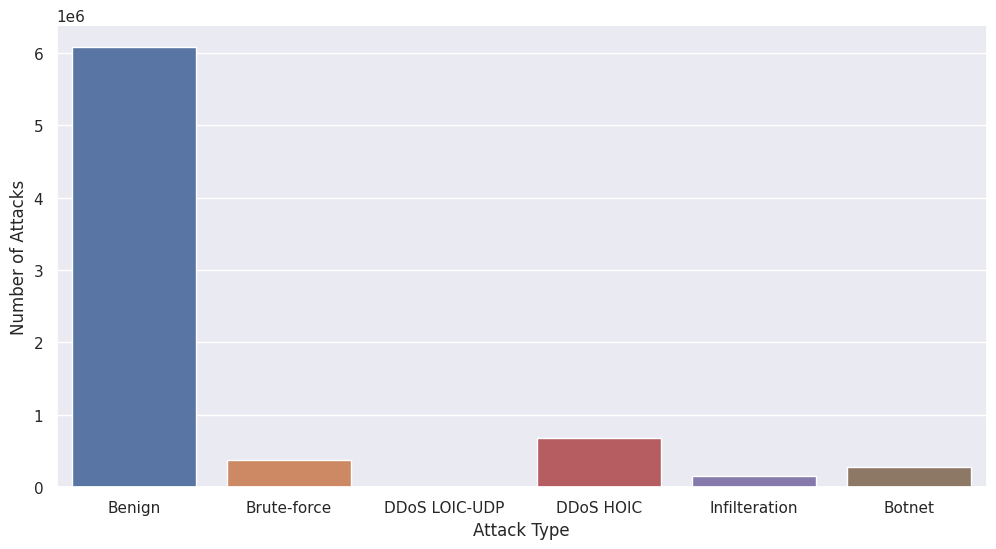

In [22]:
# make a plot number of labels
sns.set(rc={'figure.figsize':(12, 6)})
plt.xlabel('Attack Type')
sns.set_theme()
ax = sns.countplot(x='Label', data=df_all)
ax.set(xlabel='Attack Type', ylabel='Number of Attacks')
plt.show()

In [23]:
cleaned_data = df_all.dropna()
cleaned_data.isna().sum().to_numpy()

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [24]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
cleaned_data['Label']= label_encoder.fit_transform(cleaned_data['Label'])
cleaned_data['Label'].unique()

# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
#  = scaler.transform(data)

array([0, 2, 4, 3, 5, 1])

In [26]:
df_all['Label'].value_counts()

Label
Benign           6077145
DDoS HOIC         686012
Brute-force       380943
Botnet            286191
Infilteration     160639
DDoS LOIC-UDP       1730
Name: count, dtype: int64

In [25]:

cleaned_data['Label'].value_counts()

Label
0    6077145
3     686012
2     380943
1     286191
5     160639
4       1730
Name: count, dtype: int64

In [46]:
data_0 = cleaned_data[cleaned_data['Label'] == 0]
data_1 = cleaned_data[cleaned_data['Label'] == 1]
data_2 = cleaned_data[cleaned_data['Label'] == 2]
data_3 = cleaned_data[cleaned_data['Label'] == 3]
data_4 = cleaned_data[cleaned_data['Label'] == 4]
data_5 = cleaned_data[cleaned_data['Label'] == 5]
# data_6 = cleaned_data[cleaned_data['Label'] == 6]

# data_0 = cleaned_data[cleaned_data['Label'] == 0]
# # data_1 = cleaned_data[cleaned_data['Label'] == 1]
# data_2 = cleaned_data[cleaned_data['Label'] == 1]
# # data_3 = cleaned_data[cleaned_data['Label'] == 3]
# data_4 = cleaned_data[cleaned_data['Label'] == 2]
# # data_5 = cleaned_data[cleaned_data['Label'] == 5]
# # data_6 = cleaned_data[cleaned_data['Label'] == 6]


# make benign feature
y_0 = np.zeros(data_0.shape[0])
y_benign = pd.DataFrame(y_0)


y_1 = np.full(data_1.shape[0],2)
y_Botnet     = pd.DataFrame(y_1)

y_2 = np.full(data_2.shape[0], 2)
y_bf = pd.DataFrame(y_2)


y_3 = np.full(data_3.shape[0], 2)
y_DDoS_HOIC = pd.DataFrame(y_3)

y_4 = np.full(data_4.shape[0], 2)
y_DDoS_LOIC_UDP = pd.DataFrame(y_4)

y_5 = np.full(data_5.shape[0], 2)
y_Infilteration = pd.DataFrame(y_5)

# y_6 = np.full(data_6.shape[0], 2)
# y_Infilteration = pd.DataFrame(y_6)

# merging the original dataframe
X = pd.concat([data_0,data_1, data_2, data_3,data_4,data_5], sort=True)
y = pd.concat([y_benign,y_Botnet, y_bf, y_DDoS_HOIC,y_DDoS_LOIC_UDP,y_Infilteration], sort=True)

# X = pd.concat([data_0,data_1], sort=True)
# y = pd.concat([y_benign,y_Malware], sort=True)
# X = pd.concat([data_0, data_2,data_4], sort=True)
# y = pd.concat([y_benign, y_bf,y_DoSAttack], sort=True)

In [47]:
print(X.shape)
print(y.shape)

(7592660, 79)
(7592660, 1)


In [48]:
from sklearn.utils import resample

data_0_resample = resample(data_0, n_samples=50000, 
                           random_state=123, replace=True)
data_1_resample = resample(data_1, n_samples=50000, 
                           random_state=123, replace=True)
data_2_resample = resample(data_2, n_samples=2975, 
                           random_state=123, replace=True)
data_3_resample = resample(data_3, n_samples=3065, 
                           random_state=123, replace=True)
data_4_resample = resample(data_4, n_samples=1500, 
                           random_state=123, replace=True)
data_5_resample = resample(data_5, n_samples=3156, 
                           random_state=123, replace=True)
# data_6_resample = resample(data_6, n_samples=3156, 
#                            random_state=123, replace=True)

In [49]:
# train_dataset = pd.concat([data_0_resample,data_1_resample])
train_dataset = pd.concat([data_0_resample,data_1_resample, data_2_resample,data_3_resample,data_4_resample,data_5_resample])
train_dataset.head(-10)

,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
6711017,53,17,40508,2,2,64,120,32,32,32.00,...,8,0.0,0.0,0,0,0.0,0.0,0,0,0
658812,53,17,262,1,1,43,59,43,43,43.00,...,8,0.0,0.0,0,0,0.0,0.0,0,0,0
5946247,53,17,582,1,1,35,102,35,35,35.00,...,8,0.0,0.0,0,0,0.0,0.0,0,0,0
4886805,53,17,1492,1,1,35,111,35,35,35.00,...,8,0.0,0.0,0,0,0.0,0.0,0,0,0
1674493,80,6,6731453,4,4,97,232,97,0,24.25,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7132750,3389,6,1736582,8,7,1144,1581,677,0,143.00,...,20,0.0,0.0,0,0,0.0,0.0,0,0,5
6869721,49155,6,2,1,1,0,0,0,0,0.00,...,24,0.0,0.0,0,0,0.0,0.0,0,0,5
6656872,445,6,754470,5,4,373,172,140,0,74.60,...,20,0.0,0.0,0,0,0.0,0.0,0,0,5
7038937,999,6,263,1,1,0,0,0,0,0.00,...,24,0.0,0.0,0,0,0.0,0.0,0,0,5


In [50]:
train_dataset['Label'].value_counts()

Label
0    50000
1    50000
5     3156
3     3065
2     2975
4     1500
Name: count, dtype: int64

In [ ]:
# plt.figure(figsize=(10, 8))
# circle = plt.Circle((0, 0), 0.7, color='white')
# plt.title('Intrusion Attack Type Distribution')
# plt.pie(train_dataset['Label'].value_counts(), labels=['Benign', 'BF', 'BF-SSH','Bot','Infilteration'], colors=['blue', 'magenta', 'cyan','green','yellow'])
# p = plt.gcf()
# p.gca().add_artist(circle)

In [51]:
test_dataset = train_dataset.sample(frac=0.1)
target_train = train_dataset['Label']
target_test = test_dataset['Label']
target_train.unique(), target_test.unique()

(array([0, 1, 2, 3, 4, 5]), array([1, 0, 3, 5, 2, 4]))

In [52]:
y_train = to_categorical(target_train, num_classes=6)
y_test = to_categorical(target_test, num_classes=6)

In [53]:
train_dataset = train_dataset.drop(columns = [ "Label"], axis=1)
test_dataset = test_dataset.drop(columns = ["Label"], axis=1)

In [39]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# train_dataset = scaler.fit_transform(train_dataset)
# test_dataset = scaler.fit_transform(test_dataset)

In [54]:
train_dataset

,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,...,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
6711017,53,17,40508,2,2,64,120,32,32,32.000000,...,1,8,0.0,0.0000,0,0,0.0,0.000000,0,0
658812,53,17,262,1,1,43,59,43,43,43.000000,...,0,8,0.0,0.0000,0,0,0.0,0.000000,0,0
5946247,53,17,582,1,1,35,102,35,35,35.000000,...,0,8,0.0,0.0000,0,0,0.0,0.000000,0,0
4886805,53,17,1492,1,1,35,111,35,35,35.000000,...,0,8,0.0,0.0000,0,0,0.0,0.000000,0,0
1674493,80,6,6731453,4,4,97,232,97,0,24.250000,...,1,20,0.0,0.0000,0,0,0.0,0.000000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6870493,53640,6,271,1,1,0,0,0,0,0.000000,...,0,20,0.0,0.0000,0,0,0.0,0.000000,0,0
7026609,0,0,112640264,3,0,0,0,0,0,0.000000,...,0,0,0.0,0.0000,0,0,56300000.0,32.526912,56300000,56300000
7140962,53,17,311,1,1,42,58,42,42,42.000000,...,0,8,0.0,0.0000,0,0,0.0,0.000000,0,0
7137301,443,6,60092250,4,2,148,252,74,0,37.000000,...,1,20,77944.0,0.0000,77944,77944,59900000.0,0.000000,59900000,59900000


In [55]:
train_dataset.head(-10)

,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,...,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
6711017,53,17,40508,2,2,64,120,32,32,32.00,...,1,8,0.0,0.0,0,0,0.0,0.0,0,0
658812,53,17,262,1,1,43,59,43,43,43.00,...,0,8,0.0,0.0,0,0,0.0,0.0,0,0
5946247,53,17,582,1,1,35,102,35,35,35.00,...,0,8,0.0,0.0,0,0,0.0,0.0,0,0
4886805,53,17,1492,1,1,35,111,35,35,35.00,...,0,8,0.0,0.0,0,0,0.0,0.0,0,0
1674493,80,6,6731453,4,4,97,232,97,0,24.25,...,1,20,0.0,0.0,0,0,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7132750,3389,6,1736582,8,7,1144,1581,677,0,143.00,...,5,20,0.0,0.0,0,0,0.0,0.0,0,0
6869721,49155,6,2,1,1,0,0,0,0,0.00,...,0,24,0.0,0.0,0,0,0.0,0.0,0,0
6656872,445,6,754470,5,4,373,172,140,0,74.60,...,3,20,0.0,0.0,0,0,0.0,0.0,0,0
7038937,999,6,263,1,1,0,0,0,0,0.00,...,0,24,0.0,0.0,0,0,0.0,0.0,0,0


In [56]:
train_dataset = pd.DataFrame(train_dataset)
test_dataset = pd.DataFrame(test_dataset)

In [57]:
# train_dataset = train_dataset.drop(columns = ["Timestamp", "Protocol","PSH Flag Cnt","Init Fwd Win Byts","Flow Byts/s","Flow Pkts/s", "Label"], axis=1)
# test_dataset = test_dataset.drop(columns = ["Timestamp", "Protocol","PSH Flag Cnt","Init Fwd Win Byts","Flow Byts/s","Flow Pkts/s", "Label"], axis=1)
train_dataset = train_dataset.drop(columns = ["PSH Flag Cnt","Init Fwd Win Byts","Flow Byts/s","Flow Pkts/s"], axis=1)
test_dataset = test_dataset.drop(columns = ["PSH Flag Cnt","Init Fwd Win Byts","Flow Byts/s","Flow Pkts/s"], axis=1)

In [58]:
X_train = train_dataset.iloc[:, :-1].values
X_test = test_dataset.iloc[:, :-1].values
X_test



array([[8.0800e+03, 6.0000e+00, 1.4951e+04, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [8.0800e+03, 6.0000e+00, 4.9000e+02, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [8.0800e+03, 6.0000e+00, 8.3750e+03, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       ...,
       [8.0800e+03, 6.0000e+00, 4.9000e+02, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [8.0800e+03, 6.0000e+00, 1.0724e+04, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [5.2235e+04, 6.0000e+00, 4.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]])

In [59]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(110696, 73)
(11070, 73)
(110696, 6)
(11070, 6)


In [60]:
X_train = X_train.reshape(len(X_train), X_train.shape[1], 1)
X_test = X_test.reshape(len(X_test), X_test.shape[1], 1)
X_train.shape, X_test.shape

((110696, 73, 1), (11070, 73, 1))

In [61]:
from keras import Sequential
from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split
from keras.models import Sequential,Model
from keras.layers import LSTM, Dense, Bidirectional, Input,Dropout,BatchNormalization, CuDNNGRU, CuDNNLSTM,GRU,Multiply,Concatenate

from keras import backend as K
from keras.layers import Layer
from keras import initializers, regularizers, constraints

In [62]:
import tensorflow as tf
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,mode = 'min',verbose =3,min_delta=0.00,
                              patience=3, min_lr=2e-6)

In [69]:
# i_dnn = Input(shape=X_train.shape[1:],)

# x_dnn = Dense(500,input_shape=X_train.shape[1:], activation='relu')(i_dnn)
# x_dnn = BatchNormalization()(x_dnn)
# # x_dnn = Dropout(0.25)(x_dnn)

# x_dnn = Dense(300, activation='relu')(x_dnn)
# # x_dnn = BatchNormalization()(x_dnn)
# # x_dnn = Dropout(0.27)(x_dnn)

# x_dnn = LSTM(100, dropout=0.25, recurrent_dropout=0.4, activation='relu', return_sequences=True)(x_dnn)

# x_dnn = Dense(200, activation='relu')(x_dnn)
# # x_dnn = BatchNormalization()(x_dnn)
# # x_dnn = Dropout(0.25)(x_dnn)


# x_dnn = Dense(100, activation='relu')(x_dnn)
# # x_dnn = BatchNormalization()(x_dnn)
# # x_dnn = Dropout(0.25)(x_dnn)

# x_dnn = Dense(50, activation='relu')(x_dnn)
# # x_dnn = BatchNormalization()(x_dnn)
# # x_dnn = Dropout(0.25)(x_dnn)

# x_dnn = keras.layers.Flatten()(x_dnn)


# y_dnn = Dense(2, activation='softmax')(x_dnn)

# model = Model(i_dnn, y_dnn)
# model.summary()

In [43]:
# import tensorflow as tf
# model = Sequential()
# model.add(keras.layers.Input(shape=X_train[0].shape))

# # --------------
# model.add(Dense(500, activation='relu'))
# model.add(Dense(300, activation='relu'))
# # ------------
# #model.add(Bidirectional(CuDNNLSTM(500, return_sequences = True,)))
# model.add(Bidirectional(CuDNNLSTM(300, return_sequences=True)))
# model.add(Bidirectional(LSTM(200, return_sequences=True)))
# # model.add(Bidirectional(LSTM(512, recurrent_dropout=0.4, activation='relu', return_sequences=True)))
# model.add(keras.layers.Flatten())
# model.add(Dense(200, activation='relu'))
# model.add(Dense(100, activation='relu'))
# # model.add(Dense(50, activation='relu'))
# model.add(Dense(2, activation='softmax'))

# model.compile(loss='binary_crossentropy',optimizer= keras.optimizers.Adam(learning_rate=2e-3), metrics=['accuracy'])
# # model.compile(
# #     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
# #     optimizer=tf.keras.optimizers.Adam(0.01))
# print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 73, 500)           1000      
                                                                 
 dense_1 (Dense)             (None, 73, 300)           150300    
                                                                 
 bidirectional (Bidirectiona  (None, 73, 600)          1444800   
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 73, 400)          1281600   
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 29200)             0         
                                                                 
 dense_2 (Dense)             (None, 200)               5

In [81]:
from tensorflow.keras import layers


model = Sequential()
model.add(Dense(512, input_shape=X_train.shape[1:]))
model.add(CuDNNLSTM(512, return_sequences=True))
model.add(LSTM(512, return_sequences=True))
model.add(keras.layers.Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(6, activation='softmax'))

model.summary()

model.compile(
    optimizer= keras.optimizers.Adam(learning_rate=0.5e-3),
    loss='binary_crossentropy',
    metrics=['accuracy'],
)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 73, 512)           1024      
                                                                 
 cu_dnnlstm_3 (CuDNNLSTM)    (None, 73, 512)           2101248   
                                                                 
 lstm_3 (LSTM)               (None, 73, 512)           2099200   
                                                                 
 flatten_3 (Flatten)         (None, 37376)             0         
                                                                 
 dense_13 (Dense)            (None, 256)               9568512   
                                                                 
 dense_14 (Dense)            (None, 256)               65792     
                                                                 
 dense_15 (Dense)            (None, 6)                

loss ok

In [64]:
import tensorflow as tf
tf.test.is_gpu_available(
    cuda_only=False,
    min_cuda_compute_capability=None
)

True

In [70]:
# monitor='val_loss',
#     factor=0.1,
#     patience=10,
#     verbose=0,
#     mode='auto',
#     min_delta=0.0001,
#     cooldown=0,
#     min_lr=0,

In [47]:
model.compile(loss='binary_crossentropy',optimizer= keras.optimizers.Adam(learning_rate=2e-3), metrics=['accuracy'])

In [50]:
del model 

In [71]:
# model = Sequential()
# # model.add(BatchNormalization(input_shape=(X_train[0].shape)))
# model.add(Dense(512, input_shape=X_train.shape[1:]))
# model.add(Bidirectional(CuDNNLSTM(512, return_sequences = True)))
# model.add(Bidirectional(CuDNNLSTM(512, return_sequences = True)))
# # model.add(Bidirectional(LSTM(512, dropout=0.0, recurrent_dropout=0.4, activation='relu', return_sequences=True)))
# model.add(Bidirectional(CuDNNLSTM(256, return_sequences = True)))
# model.add(LSTM(64, activation='relu', return_sequences=True))

# # model.add(Attention(10))
# model.add(keras.layers.Flatten())
# model.add(Dense(512, activation='relu'))
# model.add(Dense(512, activation='relu'))
# model.add(Dense(2,activation='softmax'))
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# print(model.summary())

94.90%

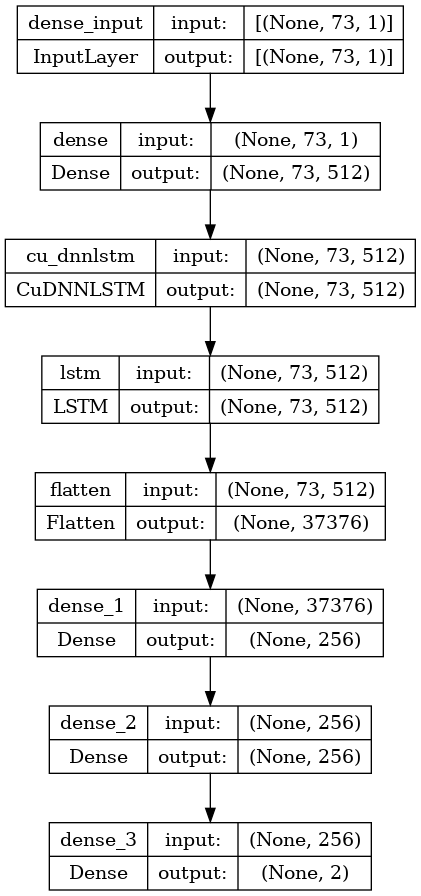

In [65]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True, rankdir='TB')

In [82]:
his = model.fit(X_train, y_train,
          batch_size=32,
          epochs=10,
          callbacks=reduce_lr,
        
          validation_data=(X_test, y_test))

Epoch 1/10
3460/3460 [==============================] - 98s 28ms/step - loss: 0.0744 - accuracy: 0.9351 - val_loss: 0.0551 - val_accuracy: 0.9531 - lr: 5.0000e-04
Epoch 2/10
3460/3460 [==============================] - 95s 27ms/step - loss: 0.0568 - accuracy: 0.9515 - val_loss: 0.0519 - val_accuracy: 0.9566 - lr: 5.0000e-04
Epoch 3/10
3460/3460 [==============================] - 95s 27ms/step - loss: 0.0466 - accuracy: 0.9586 - val_loss: 0.0413 - val_accuracy: 0.9640 - lr: 5.0000e-04
Epoch 4/10
3460/3460 [==============================] - 95s 27ms/step - loss: 0.0395 - accuracy: 0.9646 - val_loss: 0.0416 - val_accuracy: 0.9647 - lr: 5.0000e-04
Epoch 5/10
3460/3460 [==============================] - 95s 27ms/step - loss: 0.0388 - accuracy: 0.9649 - val_loss: 0.0401 - val_accuracy: 0.9659 - lr: 5.0000e-04
Epoch 6/10
3460/3460 [==============================] - 95s 27ms/step - loss: 0.0382 - accuracy: 0.9650 - val_loss: 0.0408 - val_accuracy: 0.9650 - lr: 5.0000e-04
Epoch 7/10
3460/3460 [

In [83]:
scores = model.evaluate(X_test, y_test)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))

346/346 [==============================] - 4s 12ms/step - loss: 0.0397 - accuracy: 0.9668
accuracy: 96.68%


In [84]:
# check history of model
history = his.history
history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

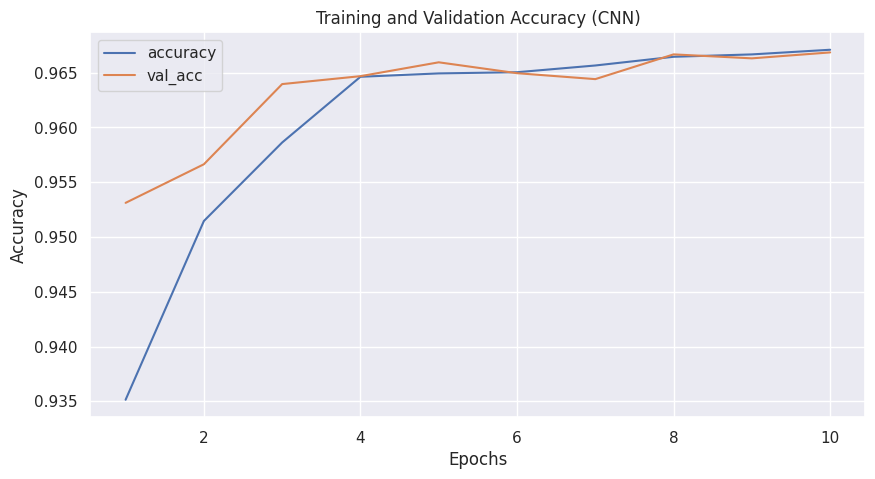

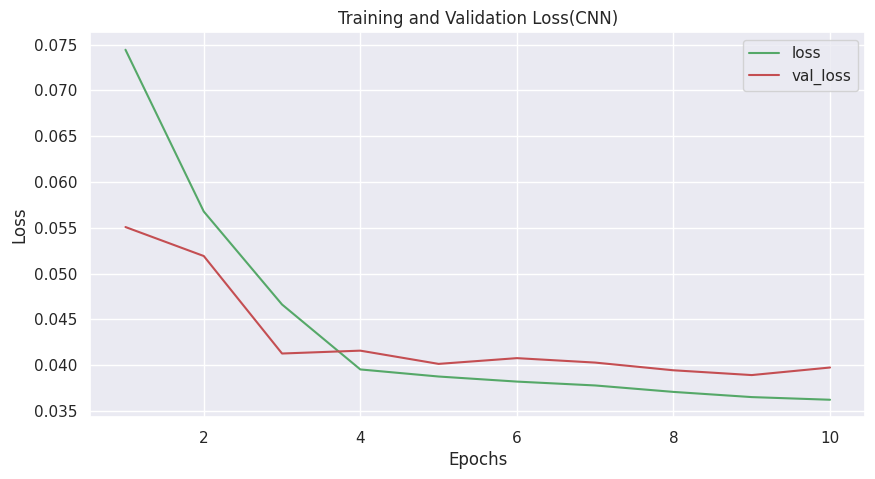

In [85]:
epochs = range(1, len(history['loss']) + 1)
acc = history['accuracy']
loss = history['loss']
val_acc = history['val_accuracy']
val_loss = history['val_loss']

# visualize training and val accuracy
plt.figure(figsize=(10, 5))
plt.title('Training and Validation Accuracy (CNN)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(epochs, acc, label='accuracy')
plt.plot(epochs, val_acc, label='val_acc')
plt.legend()

# visualize train and val loss
plt.figure(figsize=(10, 5))
plt.title('Training and Validation Loss(CNN)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(epochs, loss, label='loss', color='g')
plt.plot(epochs, val_loss, label='val_loss', color='r')
plt.legend()

346/346 [==============================] - 4s 10ms/step


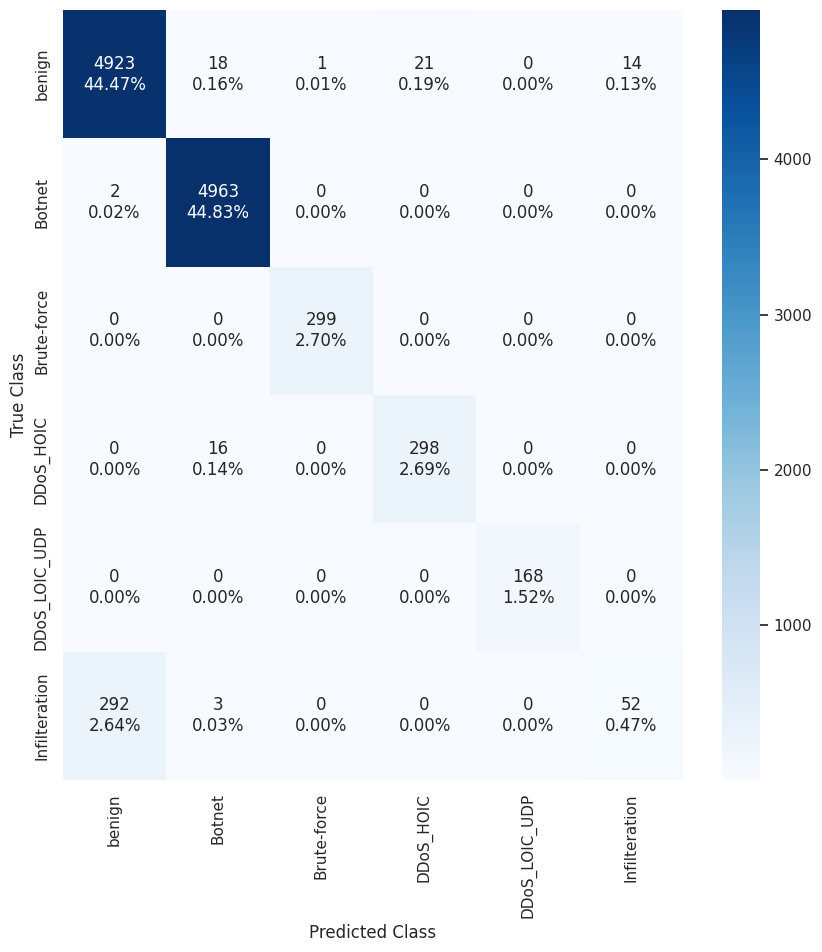

In [86]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support,  roc_curve, auc
import tensorflow as tf 
#model = tf.keras.models.load_model('/'+model_name+'.h5')

y_pred = model.predict(X_test)

y_pred_cm  = np.argmax(y_pred, axis=1)
y_test_cm  = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_test_cm, y_pred_cm) 

group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(6,6)

# label = [y_benign,y_Botnet, y_bf, y_DDoS_HOIC,y_DDoS_LOIC_UDP,y_Infilteration]
label = ['benign','Botnet','Brute-force','DDoS_HOIC','DDoS_LOIC_UDP','Infilteration']

plt.figure(figsize=(10,10))
sns.heatmap(cm, xticklabels=label, yticklabels=label, annot=labels, fmt='', cmap="Blues", vmin = 0.2);
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

In [87]:
from sklearn.metrics import classification_report



print(classification_report(y_test_cm, y_pred_cm, target_names= ['benign','Botnet','Brute-force','DDoS_HOIC','DDoS_LOIC_UDP','Infilteration']))
                            
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))



               precision    recall  f1-score   support

       benign       0.94      0.99      0.97      4977
       Botnet       0.99      1.00      1.00      4965
  Brute-force       1.00      1.00      1.00       299
    DDoS_HOIC       0.93      0.95      0.94       314
DDoS_LOIC_UDP       1.00      1.00      1.00       168
Infilteration       0.79      0.15      0.25       347

     accuracy                           0.97     11070
    macro avg       0.94      0.85      0.86     11070
 weighted avg       0.96      0.97      0.96     11070

346/346 [==============================] - 4s 12ms/step - loss: 0.0397 - accuracy: 0.9668
Test: accuracy = 0.966847  ;  loss = 0.039736
